# Identify Fraud from Enron Email 

Enron scandal is one of the most famous scandals in the world. Because of the fraud, Enron went bankrupt in 2002. I heard and learnt a lot about it since day one in business school. During that time, all I learnt was about how did they cheat on their financial statement, but why Arthur Andersen, the auditor, did not find out. 

I was very excited when I knew there are tens of thousands of emails and detailed financial data for top executives, which I have never heard or thought about before. By playing around with these datasets, I can become a detective, my dreamy job when I was a kid after watching a lot Case Closed, to identify person of interest. 

In this project, I will apply what I my machine learning knowledge in this project to build up algorithms to find out who were involved in the scandle, meaning they were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

The main code will be stored in poi_id.py file.

## Dataset/Questions

The dataset I am going to use includes the financial and email information of people related to the scandle. The information will be read to a dictionary. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

* financial features (all units are in US dollars)
    * 'salary'
    * 'deferral_payments'
    * 'total_payments'
    * 'loan_advances'
    * 'bonus'
    * 'restricted_stock_deferred'
    * 'deferred_income'
    * 'total_stock_value'
    * 'expenses'
    * 'exercised_stock_options'
    * 'other'
    * 'long_term_incentive'
    * 'restricted_stock'
    * 'director_fees'


* email features (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
    * 'to_messages'
    * 'email_address'
    * 'from_poi_to_this_person'
    * 'from_messages'
    * 'from_this_person_to_poi'
    * 'shared_receipt_with_poi'


* POI label (boolean, represented as integer)
    * ‘poi' 
    
    
The question to answer and the goal of this project is to find out what features are related to the person of interest. When there are information without poi labels, the machine learning algorithm will be able to figure out whether this person is person of interest or not.

## Setup

In [23]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

%matplotlib inline
matplotlib.style.use('ggplot')

## Explore

I will explore some key characteristics of this dataset before digging into further analysis.

In [24]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

Total number of data points

In [25]:
len(data_dict)

146

Number of poi vs. Number of non-poi

In [28]:
count_poi = 0
count_non_poi = 0
    
for k, v in data_dict.items():
    if v['poi']:
        count_poi += 1
    else:
        count_non_poi +=1

print "Number of poi: ", count_poi
print "Number of non-poi:", count_non_poi

Number of poi:  18
Number of non-poi: 128


Number of features

In [29]:
for _, v in data_dict.items():
    print len(v)
    break

21


Are there any missing values?

In [32]:
for _, v in data_dict.items():
    for features_values in v.values():
        if features_values == "NaN":
            print "There are missing values"
            break
        else:
            print "No missing values"

No missing values
No missing values
There are missing values
No missing values
There are missing values
No missing values
There are missing values
There are missing values
No missing values
No missing values
There are missing values
No missing values
There are missing values
There are missing values
No missing values
No missing values
There are missing values
There are missing values
No missing values
No missing values
No missing values
No missing values
No missing values
No missing values
No missing values
No missing values
No missing values
No missing values
No missing values
There are missing values
No missing values
No missing values
No missing values
No missing values
No missing values
There are missing values
No missing values
No missing values
There are missing values
No missing values
No missing values
There are missing values
No missing values
No missing values
There are missing values
There are missing values
There are missing values
No missing values
No missing values
No mis

## Remove Outliers

The dataset we have may not be clean. There might be some outliers hidden inside that can affect our analysis. Therefore, it is essential to discover those outliers and remove them before conducting further analysis. The features I will start to explore are 'salary' and 'poi'.

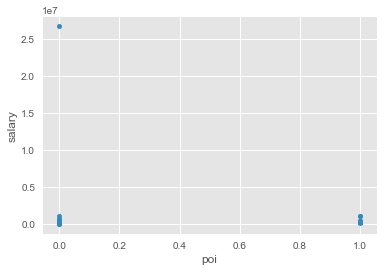

In [66]:
%run outliers.py

There is one point in the dataset that is significantly different from others. It is a good idea to read through the names to find out which data point is the outliers.

In [67]:
for key in enron_dataset.keys():
    print key

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F
HUMPHREY GENE E
UMANOFF ADAM S
BLACHMAN JEREMY M
SUNDE MARTIN
GIBBS DANA R
LOWRY CHARLES P
COLWELL WESLEY
MULLER MARK S
JACKSON CHARLENE R
WESTFAHL RICHARD K
WALTERS GARETH W
WALLS JR ROBERT H
KITCHEN LOUISE
CHAN RONNIE
BELFER ROBERT
SHANKMAN JEFFREY A
WODRASKA JOHN
BERGSIEKER RICHARD P
URQUHART JOHN A
BIBI PHILIPPE A
RIEKER PAULA H
WHALEY DAVID A
BECK SALLY W
HAUG DAVID L
ECHOLS JOHN B
MENDELSOHN JOHN
HICKERSON GARY J
CLINE KENNETH W
LEWIS RICHARD
HAYES ROBERT E
MCCARTY DANNY J
KOPPER MICHAEL J
LEFF DANIEL P
LAVORATO JOHN J
BERBERIAN DAVID
DETMERING TIMOTHY J
WAKEHAM JOHN
POWERS WILLIAM
GOLD JOSEPH
BANNANTINE JAMES M
DUNCAN JOHN H
SHAPIRO RICHARD S
SHERRIFF JOHN R
SHELBY REX
LEMAISTRE CHARLES
DEFFNER JOSEPH M
KISHKILL JOSEPH G
WHALLEY LAWRENCE G
MCCONNELL MICHAEL S
PIRO JIM
DELAINEY DAVID W
SULLIVAN-SHAKLOVITZ COLLEEN
WROBEL BRUC

There is a key named "TOTAL", which should be the sum of all the other dataset. It is a good idea to remove it.

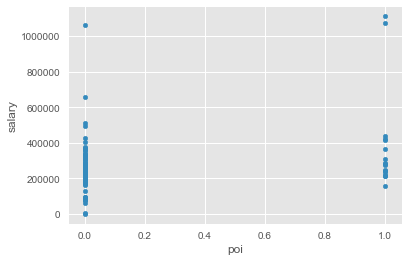

In [68]:
%run outliers.py

There are still some outliers, but it could because they have their special characteristics that make them stand out. I will draw all the other figures to scan through to make sure no significant outliers.

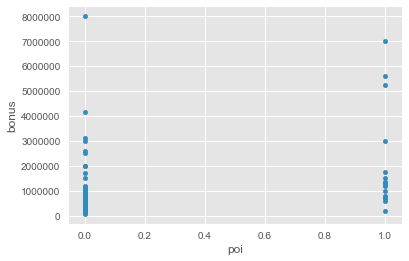

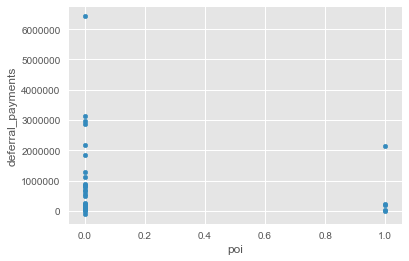

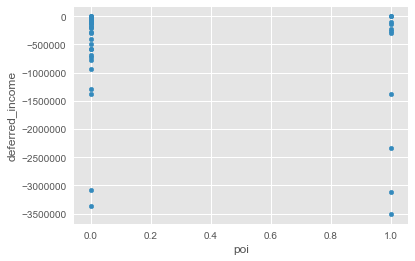

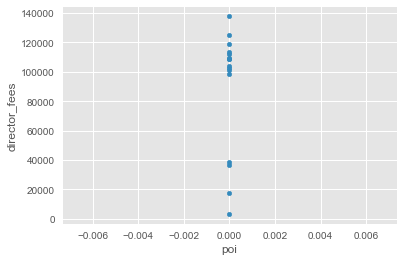

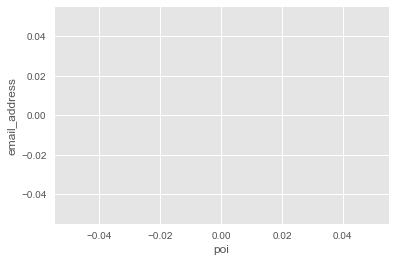

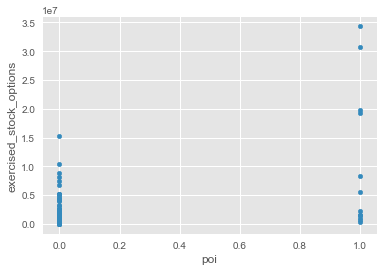

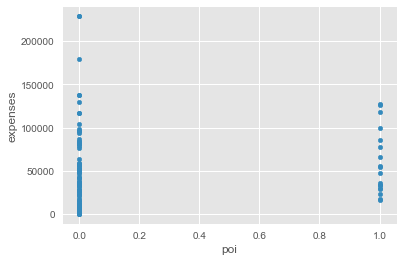

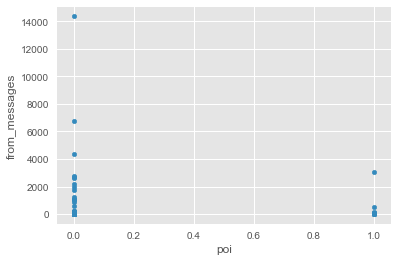

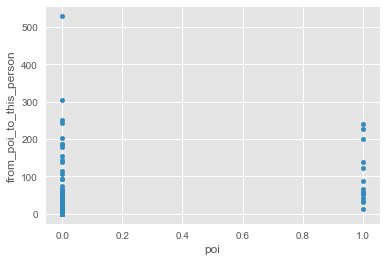

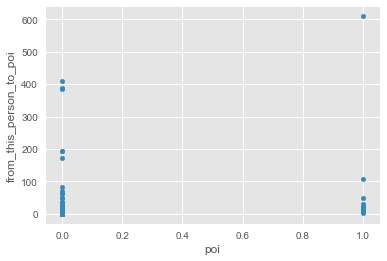

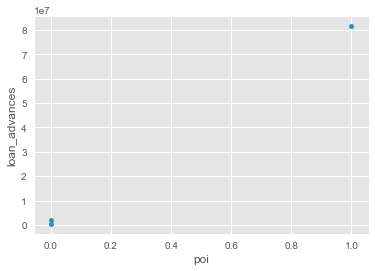

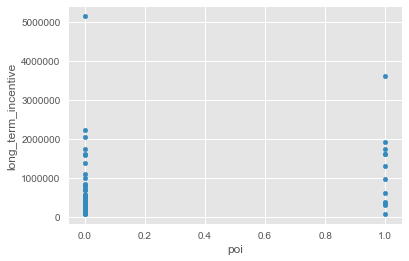

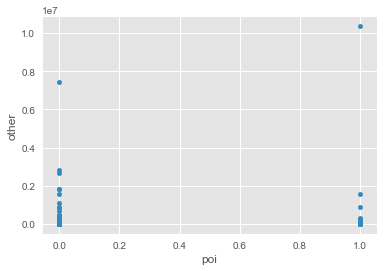

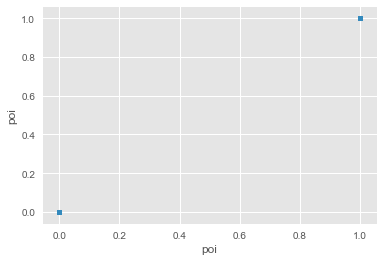

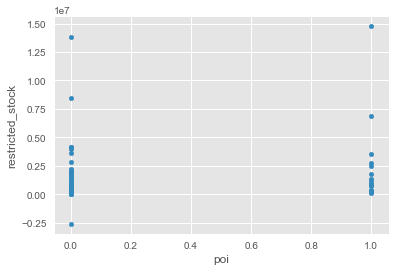

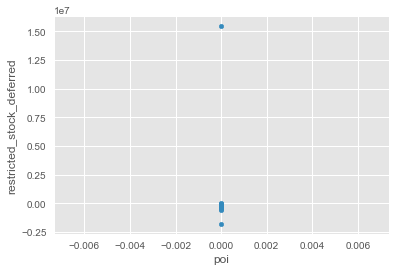

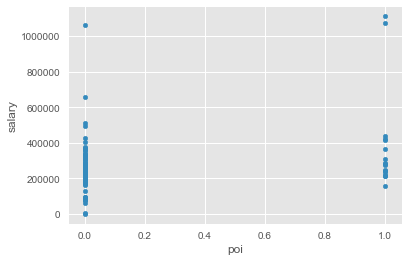

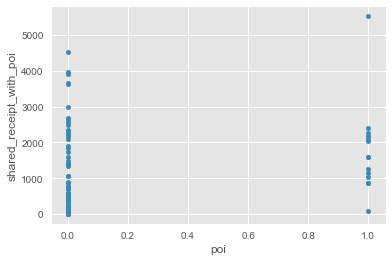

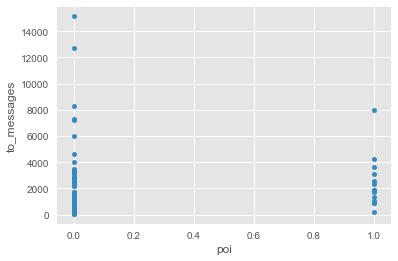

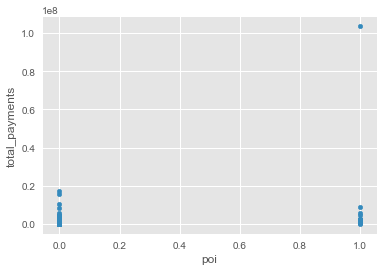

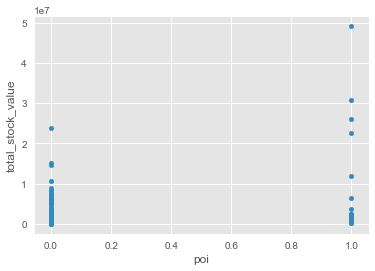

In [74]:
%run outliers.py

There are several points stand out that I want to explore a little bit more. However, since we do not have a lot data in this dataset, I will not remove those potential outliers right now. I might remove them later.

There is one non-poi with significantly high bonus amount.

In [85]:
for k, v in enron_dataset.items():
    if v['bonus'] != "NaN" and v['bonus'] > 7000000:
        print k, ":", v['bonus']

LAVORATO JOHN J : 8000000


After looking through the original data, this person does have a significantly high bonus comparing with his salary. Normally people with very high bonus are likely to be a poi. It is possible that he is an outlier. 

There is another person with significantly high deferral payments amount.

In [87]:
for k, v in enron_dataset.items():
    if v['deferral_payments'] != "NaN" and v['deferral_payments'] > 6000000:
        print k, ":", v['deferral_payments']

FREVERT MARK A : 6426990


People with a lot deferred payments are concerned more with the company's long-term development. Hence, they are less likely to be a poi. This data point proves it. He is not an outlier.

An poi has a very high total payment.

In [89]:
for k, v in enron_dataset.items():
    if v['total_payments'] != "NaN" and v['total_payments'] > 100000000:
        print k, ":", v['total_payments']

LAY KENNETH L : 103559793


He is the CEO of Enron during that time. It is not unusual for him to earn a lot and involve in the scandal. He is not an outlier.

There are some other interesting things I noticed. Two factors, restricted stock deferred and director fee, have too many "NaN", and all people have these information are non-poi. These two features cannot provide much information. Therefore, they will be exclude from further analysis.

## Feature Selection

There are many features available, but not all of them are as informative as others. 

For financial related features, by looking through the original dataset, we can see there are many features, like Loan Advances and Deferral Payments have too many missing points. Therefore, they are not very helpful in the analysis. Also, it is helpful not only to check the numbers, but to check the ratios. For example, only checking salary and bonus amounts may not be as effective as the bonus to salary ratio.

For email related features, there are not many missing data. I will also add some other ratio factors, like email related to poi to total emails ratio.

In [123]:
%run features.py

## Algorithms

Since the amounts within each feature are not in the same range. Before applying any algorithms, I need to first do some feature scaling. I will use minimum and maximum scaler. 

We have many options for algorithms. I will first choose the use decision tree. I will tune the parameters using GridSearchCV. Although we do not have a large dataset, I will still split the dataset into training and testing dataset for the first algorithms I use.

### Decision Tree

In [128]:
%run algorithms.py

decision tree accuracy score:  0.789473684211
decision tree precision_score:  0.333333333333
decision treere call_score 0.333333333333


This is not a bad attempt. I will try some other algorithms as well.

### SVM

In [14]:
%run algorithms.py

svc accuracy score:  0.730769230769
svc precision_score:  0.0
svc recall_score 0.0


This is not a very good algorithms in this dataset.

### KNN

In [17]:
%run algorithms.py

knn accuracy score:  0.807692307692
knn precision_score:  0.666666666667
knn recall_score 0.333333333333


This is the best one among all the three.

### AdaBoost

In [21]:
%run algorithms.py

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in divide
  sample_weight /= sample_weight_sum
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:578: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:603: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)


adaboost accuracy score:  0.116279069767
adaboost precision_score:  0.116279069767
adaboost recall_score 1.0
adaboost accuracy score:  0.627906976744
adaboost precision_score:  0.277777777778
adaboost recall_score 0.625
adaboost accuracy score:  0.860465116279
adaboost precision_score:  0.333333333333
adaboost recall_score 0.2


## Validation & Evaluation

I applied several validation techniques within the algorithms. I split the whole dataset into training and testing dataset. I also tried to use Kfold to cross validate my algorithms. Validation is very important in machine learning process. It can help us better understand how well the algorithms, and avoid overfitting. 

I tried several different algorithms and tuned each of them. It seems that K neighbors classifier is the best option here. It has 0.67 precision score and 0.33 recall score. Precision rate measures that given all the poi I predicted, what percentage of them are real poi. Recall score measures that given all the real poi, what percentage of them I predict successfully. The two scores are better measure than just the accuracy score, which simply measures the percentage of my sucessful predication rate. 